In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from astropy import units as u

In [26]:
nombre = "Francisco Montenegro"

### Functions to select frequency ranges in a SED

In [27]:
def select_frequency_window(f,s,minf,maxf):
    """ 
    Given a frequency vector f and a flux vector s, it selects those SED points within minf and maxf,
    both included.
    """
    fout = []
    sout = []
    for i in range(len(f)):
        if f[i]>=minf and f[i]<=maxf and (not np.isnan(s[i])):
            fout.append(f[i].to('Hz').value)
            sout.append(s[i].to('Jy').value)
            
    fout = np.array(fout).reshape(-1,1)*u.Hz
    sout = np.array(sout).reshape(-1,1)*u.Jy
    return fout,sout    

def select_radio(freq,s,min_freq_radio=100*u.MHz,max_freq_radio=100*u.GHz):
    # Tailored for radio, with default parameters for minf and maxf
    freq_radio, s_radio = select_frequency_window(freq, s, min_freq_radio,max_freq_radio)
    return freq_radio, s_radio

def p_electrom_from_alfa(alpha):
    return 1-2*alpha

## Descarga de SED de dos radiofuentes en NED
NASA Extragalactic Database - https://ned.ipac.caltech.edu

## 3C295 y Cassiopeia A

In [28]:
from astropy.io.votable import parse_single_table

# Ejemplo para la sed de 3C273
sed_3C273 = parse_single_table("3C273-votable1.vot")


In [29]:
for field in sed_3C273.iter_fields_and_params():
    print(field)

<FIELD ID="photo_col1" datatype="int" name="No." ucd="meta.number;phot.mag"/>
<FIELD ID="photo_col2" arraysize="*" datatype="char" name="Observed Passband" ucd="instr.bandpass"/>
<FIELD ID="photo_col3" datatype="double" name="Photometry Measurement" ucd="phot"/>
<FIELD ID="photo_col4" arraysize="*" datatype="char" name="Uncertainty" ucd="stat.error;phot"/>
<FIELD ID="photo_col5" arraysize="*" datatype="char" name="Units" ucd="meta.unit;phot"/>
<FIELD ID="photo_col6" datatype="double" name="Frequency" ucd="em.freq" unit="Hz"/>
<FIELD ID="photo_col7" datatype="double" name="Flux Density" ucd="phot" unit="Jy"/>
<FIELD ID="photo_col8" datatype="double" name="Upper limit of uncertainty" ucd="meta.code.error;stat.max"/>
<FIELD ID="photo_col9" datatype="double" name="Lower limit of uncertainty" ucd="meta.code.error;stat.min"/>
<FIELD ID="photo_col10" datatype="double" name="Upper limit of Flux Density" ucd="phot;stat.max"/>
<FIELD ID="photo_col11" datatype="double" name="Lower limit of Flux D

In [31]:
# Extraemos los datos de la tabla que están almacenados en el atributo array
data = sed_3C273.array

In [32]:
# Accedemos a la columna de frecuecias por su nombre en la lista de atributos anterior. Se llama "Frequency"
# Vemos también que las unidades de frecuencia son unit="Hz"
freq=data['Frequency']*u.Hz
freq

<Quantity [2.43e+14, 2.43e+14, 1.80e+14, 1.80e+14, 1.39e+14, 1.39e+14,
           8.94e+13, 8.94e+13, 8.94e+13, 8.44e+13, 8.44e+13, 6.67e+13,
           6.67e+13, 6.51e+13, 6.51e+13, 6.51e+13, 5.23e+13, 5.23e+13,
           3.81e+13, 3.81e+13, 2.59e+13, 2.59e+13, 2.59e+13, 1.36e+13,
           1.36e+13, 1.36e+13, 1.27e+13, 1.27e+13, 1.07e+10, 5.00e+09,
           4.85e+09, 4.85e+09, 4.83e+09, 2.70e+09, 1.40e+09, 1.40e+09,
           7.50e+08, 4.08e+08, 4.08e+08, 3.65e+08, 1.78e+08, 1.78e+08,
           7.38e+07, 3.80e+07, 2.63e+07, 2.23e+07] Hz>

In [33]:
# Accedemos a la columna de flujos por su nombre en la lista de atributos anterior. Se llama "Flux Density"
# Vemos también que las unidades de flujo son unit="Jy"

flux=data['Flux Density']*u.Jy
flux

<Quantity [2.80e-03, 2.84e-03, 2.68e-03, 2.68e-03, 1.77e-03, 1.93e-03,
           9.76e-04, 9.90e-04, 1.59e-03, 8.52e-04, 8.58e-04, 5.58e-04,
           5.53e-04, 5.28e-04, 5.17e-04, 8.41e-04, 3.59e-04, 3.60e-04,
           1.91e-04, 2.06e-04, 3.23e-04,      nan, 7.76e-04,      nan,
                nan,      nan,      nan,      nan, 2.00e-01, 5.20e-01,
           3.93e-01, 4.00e-01, 4.34e-01, 8.60e-01, 1.67e+00, 1.80e+00,
           3.10e+00, 5.01e+00, 5.14e+00, 5.88e+00, 8.70e+00, 9.00e+00,
           1.52e+01, 1.70e+01, 3.30e+01, 5.20e+01] Jy>

Para hacer el ajuste vamos a seleccionar los puntos de la SED que pertenecen solamente a la parte radio del espectro, donde esperamos que se encuentre la contribución de la radiación sincrotrón que se comporte como una ley de potencias $S \propto \nu^{\alpha}$

In [34]:
# Usamos la función definida arriba
freq_radio, flux_radio = select_radio(freq,flux, min_freq_radio=100*u.MHz,max_freq_radio=4.5*u.GHz)

# Calculamos los logaritmos para poder hacer un ajuste lineal y calcular la pendiente
log_freq_radio = np.log10(freq_radio.value)
log_flux_radio = np.log10(flux_radio.value)

In [36]:
print(flux_radio)

[[0.86]
 [1.67]
 [1.8 ]
 [3.1 ]
 [5.01]
 [5.14]
 [5.88]
 [8.7 ]
 [9.  ]] Jy


In [37]:
print(freq_radio)

[[2.70e+09]
 [1.40e+09]
 [1.40e+09]
 [7.50e+08]
 [4.08e+08]
 [4.08e+08]
 [3.65e+08]
 [1.78e+08]
 [1.78e+08]] Hz


In [ ]:
# Calculamos la pendiente del ajuste de log_flux_radio frente a log_freq_radio

# alpha = 

Como sabemos que la relación entre 

El indice espectral de energía de los electrones es N(E) = E$^{-p}$ dE

Para calcularlo usamos la función definida arriba p = 1-2$\alpha$

In [ ]:
# p = 1 - 2 * alpha



Text(0, 0.5, 'log(Flux [Jy])')

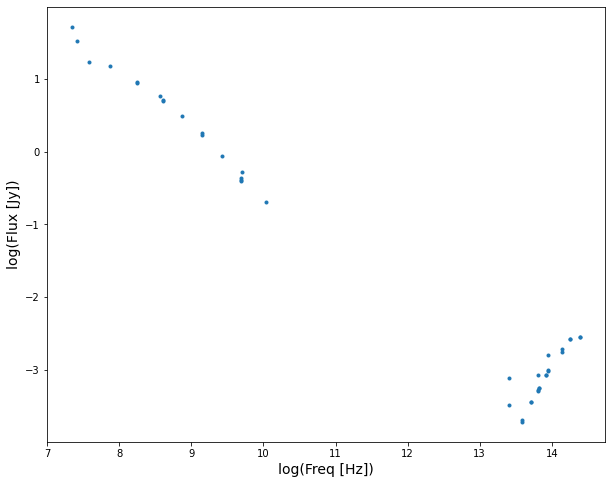

In [44]:
plt.figure(figsize=(10,8))
plt.scatter(np.log10(freq.value),np.log10(flux.value),marker = '.')
plt.xlabel('log(Freq [Hz])',fontsize=14)
plt.ylabel('log(Flux [Jy])',fontsize=14)

# Dibujamos también el modelo del ajuste lineal y ponemos como título del gráfico el valor de alpha
